In [5]:
!pip install qiskit

# !pip install qiskit-aer # qiskit-aer랑 qiskit-aer-gpu랑 exclusive해서 얘는 지워야함.

!pip install matplotlib
!pip install qiskit-aer-gpu
!apt update
!apt install -y nvidia-cuda-toolkit
!pip install cupy-cuda11x
!pip install pylatexenc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 54.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 80.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 42.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.8/18.8 MB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 895.1/895.1 kB 67.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 72.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.3/363.3 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.3/130.3 MB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.2/209.2 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd /content/drive/MyDrive/Research/Fault-tolerance/Flag\ qubit

/content/drive/MyDrive/Research/Fault-tolerance/Flag qubit


In [6]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import transpile
from qiskit_aer import Aer, AerSimulator
# Import from Qiskit Aer noise module
from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error)
from qiskit.visualization import plot_histogram
from FT_Gadgets.FT_prep_zero import FT_prep_zero
from FT_Gadgets.FT_EC import FT_EC
from FT_Gadgets.FT_gate import FT_Hadamard, FT_CNOT
from FT_Gadgets.FT_meas import decode_steane, FT_meas
from Noise_models import noise_model, custom_noise_model, occur_random_single_fault
from qiskit.circuit import CircuitInstruction, Instruction
import random

In [11]:
def non_encoded_bell(p=0.001,shots=10000):
    q1 = QuantumRegister(1, 'sys1')
    q2 = QuantumRegister(1, 'sys2')
    test = ClassicalRegister(2, 'test')
    qc = QuantumCircuit(q1,q2,test)

    qc.reset(q1[0])
    qc.reset(q2[0])
    qc.h(q1[0])
    qc.cx(q1[0],q2[0])
    qc.measure(q1,test[0])
    qc.measure(q2,test[1])
    qc.draw('mpl')
    sim_noise = AerSimulator(noise_model=noise_model(qc,p), shots=shots)
    circ_tnoise = transpile(qc, sim_noise)

    result = sim_noise.run(circ_tnoise).result()
    counts = result.get_counts(0)
    error_counts = 0
    total_counts = 0
    # count '10' and '01'
    for bitstring, count in counts.items():
        total_counts += count
        if bitstring in ['01', '10']:
            error_counts += count
        pass

    ratio = error_counts / total_counts
    print(f"Ratio of 01 and 10: {ratio:.6f}")
    print(total_counts)
    return ratio, total_counts


In [17]:
# A100 GPU로 1000 shot에 29초
def FT_bell(p=0.001,shots=10000):
  n=7
  q1 = QuantumRegister(n,'sys1')
  q2 = QuantumRegister(n,'sys2')
  flag = QuantumRegister(1,'flag')
  cpf1 = ClassicalRegister(1,'cpf1') # cbit for flag of fault-tolerant prep gadget.
  cpf2 = ClassicalRegister(1,'cpf2')
  csyn = ClassicalRegister(6,'csyn')
  syn = QuantumRegister(1,'syn')
  cflag = ClassicalRegister(1,'cflag')
  test1 = ClassicalRegister(7,'test1')
  test2 = ClassicalRegister(7,'test2')

  qc = QuantumCircuit(q1,q2,flag,syn,csyn,cflag,cpf1,cpf2,test1,test2)
  FT_prep_zero(qc,q1,flag,cpf1,max_trials=5)
  FT_prep_zero(qc,q2,flag,cpf2,max_trials=5)
  FT_EC(qc,q1,syn=syn,flag=flag,csyn=csyn,cflag=cflag)
  FT_EC(qc,q2,syn=syn,flag=flag,csyn=csyn,cflag=cflag)
  FT_Hadamard(qc,q1)
  FT_EC(qc,q1,syn=syn,flag=flag,csyn=csyn,cflag=cflag)
  FT_CNOT(qc,q1,q2)
  FT_EC(qc,q1,syn=syn,flag=flag,csyn=csyn,cflag=cflag)
  FT_EC(qc,q2,syn=syn,flag=flag,csyn=csyn,cflag=cflag)
  qc.measure(q1,test1)
  qc.measure(q2,test2)
  # qc.measure(q1[0],c1[0])

  # qc.draw('mpl')
  sim_noise = AerSimulator(noise_model=noise_model(qc,p), shots=shots)
  sim_noise.set_options(device="GPU",method="statevector")
  # for i, inst in enumerate(qc.data):
  #   print(inst)

  # Transpile circuit for noisy basis gates
  circ_tnoise = transpile(qc, sim_noise)

  # Run and get counts
  result = sim_noise.run(circ_tnoise).result()
  counts = result.get_counts(0)

  total_count = 0
  error_count = 0
  for bitstring, count in counts.items():
    # print(bitstring)
    # cpf1 18 cpf2 16
    # test1 8:15 test2 0:7
    if bitstring[18] == '0' and bitstring[16] == '0': # if |0>|0> fault-tolerantly prepared
      # decode
      bit1 = decode_steane(bitstring[8:15])
      bit2 = decode_steane(bitstring[0:7])
      total_count += count
      if bit1 != bit2:
        error_count += count

  ratio = error_count / total_count
  return ratio, total_count

# p = 0.1 -> p_L = 0.128866
# p = 0.01 -> p_L = 0.001767
# p = 0.001 -> p_L = 0.000020, 0.000010
# p_L = O(p^2)맞는 듯

In [20]:
FT_bell(p=0.01,shots=1000)

(0.211, 1000)

In [18]:
FT_bell(shots=1000)

(0.003, 1000)

In [21]:
FT_bell(p=0.0001,shots=1000)

(0.0, 1000)

<ipython-input-22-764cae8311a7>:13: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(p_values), np.log10(ratio_values))


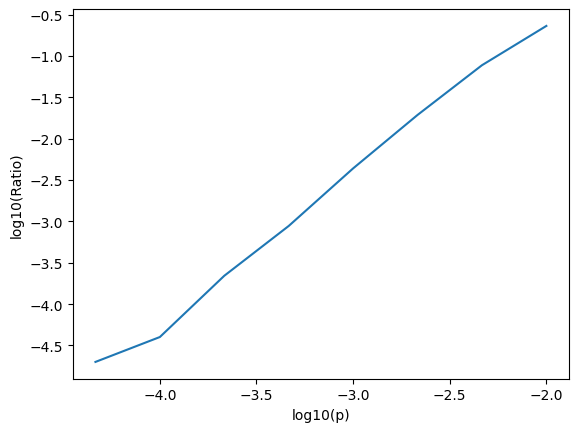

In [ ]:
# prompt: p에 따라 FT_prep_simul(p)의 ratio값 logscale로 그래프 그리기

import numpy as np
import matplotlib.pyplot as plt

p_values = np.logspace(-5,-2,10)
ratio_values = []

for p in p_values:
  ratio, _ = FT_bell(p,shots=100000)
  ratio_values.append(ratio)

plt.plot(np.log10(p_values), np.log10(ratio_values))
plt.xlabel("log10(p)")
plt.ylabel("log10(Ratio)")
plt.show()


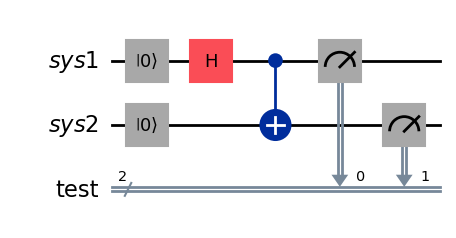

In [14]:
q1 = QuantumRegister(1, 'sys1')
q2 = QuantumRegister(1, 'sys2')
test = ClassicalRegister(2, 'test')
qc = QuantumCircuit(q1,q2,test)

qc.reset(q1[0])
qc.reset(q2[0])
qc.h(q1[0])
qc.cx(q1[0],q2[0])
qc.measure(q1,test[0])
qc.measure(q2,test[1])
qc.draw('mpl')

In [ ]:
n=7
q1 = QuantumRegister(n,'sys1')
anc1 = QuantumRegister(1,'flag1')
c1 = ClassicalRegister(1,'c1')
csyn1 = ClassicalRegister(6,'csyn')
syn1 = QuantumRegister(1,'syn')
cflag1 = ClassicalRegister(1,'cflag1')
test = ClassicalRegister(7,'test')
# q2 = QuantumRegister(n,'sys2')
# anc2 = QuantumRegister(1,'flag2')
# c2 = ClassicalRegister(1,'c2')
qc = QuantumCircuit(q1,anc1,syn1,csyn1,cflag1,c1,test)
FT_prep_zero(qc,q1,anc1,c1,max_trials=1)
FT_EC(qc,q1,syn=syn1,flag=anc1,csyn=csyn1, cflag=cflag1)
# qc.measure(q1[0],c1[0])
qc.measure(q1,test)
qc.draw('mpl')